# Hierarchical Photo-z's on Mock HSC Data

Part 7.1 of a series of notebooks used to derive the results shown in Speagle et al. (2017).

This notebook applies the results from Part 4/5 (run over mock SDSS/HSC data, respectively) to **real** HSC data. It focuses on cross-validation using a large, heterogeneous training sample.

## Setup

In [1]:
import sys # system commands
import pickle # saving data
from scipy import stats # statistics functions
from scipy import special # special functions
from scipy import interpolate # interpolation
from sklearn.neighbors import KernelDensity # kernel density estimation
from pandas.tools.plotting import autocorrelation_plot # autocorrelation plot
from astropy.io import fits # reading fits files

# simulation
import make_sim as sim

# FRANKEN-Z
import frankenz as fz

%pylab
%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


## Data

The data we'll use here is the same data used to compute HSC S16A photo-z's. (This data is private at the moment; a blinded version of the catalog might eventually be made public.)

In [2]:
# load observed data
hdul = fits.open('/Users/Josh/Dropbox/HSC/HSC_photoz/catalogs/hsc_s16a_combined_specz_highq_clean_errsim_train_v1.fits')
data = hdul[1].data
Nobs = len(data)
print 'Training objects:', Nobs

Training objects: 373432


This is approximately a factor of 4 larger than the SDSS dataset, and represents a perfect test case for our hierarchical model.

In [3]:
# initializing photometry

aphot = 10 ** (-0.4 * c_[data['a_g'], data['a_r'], data['a_i'], data['a_z'], data['a_y']])
phot = c_[data['gparent_flux_convolved_2_1'], data['rparent_flux_convolved_2_1'], 
          data['iparent_flux_convolved_2_1'], data['zparent_flux_convolved_2_1'], 
          data['yparent_flux_convolved_2_1']] * aphot
err = c_[data['gflux_aperture15_err'], data['rflux_aperture15_err'], 
         data['iflux_aperture15_err'], data['zflux_aperture15_err'], 
         data['yflux_aperture15_err']] * aphot
pkern = ones(5) * 0.03 # smoothing kernel
err = sqrt(err**2 + (pkern*phot)**2) # add kernel to training objects
mask = isfinite(phot) & isfinite(err) & (err > 0.)
print 'Median correction:', median(aphot,axis=0)

csel = mask.sum(axis=1) < 5
print 'Number of censored objects:', csel.sum()

data = data[~csel]
phot, err, mask = phot[~csel], err[~csel], mask[~csel]

Nobs = len(phot)
print 'Training objects (cleaned):', Nobs

Median correction: [ 0.94042301  0.95740581  0.96941328  0.97632635  0.97976404]
Number of censored objects: 3
Training objects (cleaned): 373429


In [4]:
# initialize asinh magnitudes (Luptitudes)
flux_zeropoint = 10**(-0.4*-23.9) # AB magnitude zeropoint
depth_hsc = array([26.5, 26.1, 25.9, 25.1, 24.4]) # 5-sigma limiting magnitudes
fdepth_hsc = 10**(-0.4*(depth_hsc-23.9)) / 5
mag, magerr = fz.asinh_mag_map(phot, err, skynoise=fdepth_hsc, zeropoints=flux_zeropoint)

In [5]:
# read FRANKEN-Z config files (to get dictionaries)
config = fz.ReadParams('config/frankenz.config')

# initialize supplementary dictionaries
mdict = fz.PDFDict(config.CONFIG_MAG.params) # magnitude dict
cdict = fz.PDFDict(config.CONFIG_COLOR.params) # color dict
magidx, mageidx = mdict.fit(mag, magerr)

In [6]:
# initialize redshift dictionary
rdict = fz.RedshiftDict(config.CONFIG_REDSHIFT.params)

# add names so easier to reference later
rdict.sig_dict = rdict.lze_dict
rdict.sig_width = rdict.lze_width
rdict.delta = rdict.dlz_highres
rdict.grid = rdict.lzgrid_highres
rdict.Ngrid = rdict.Nz_highres

# discretize redshifts
lz, lze = log(1+data['redshift']), data['redshift_err']/(1+data['redshift'])
lze[data['redshift_err']<=0.] = 0.
lzidx, lzeidx = rdict.fit(lz, sqrt(lze**2 + rdict.dlz**2))

Unlike our SDSS data, the training data for HSC is heterogeneous, cobbled together from a bunch of different surveys with a bunch of different selection effects. These include three broad "classes" of redshifts: spectroscopic redshifts (spec-z's) from a host of surveys (SDSS, DEEP2, GAMA, zCOSMOS, etc.); grism and/or prism-based redshifts (g/prism-z's) from 3DHST and PRIMUS, respectively; and many-band photometric redshifts from COSMOS and 3DHST.

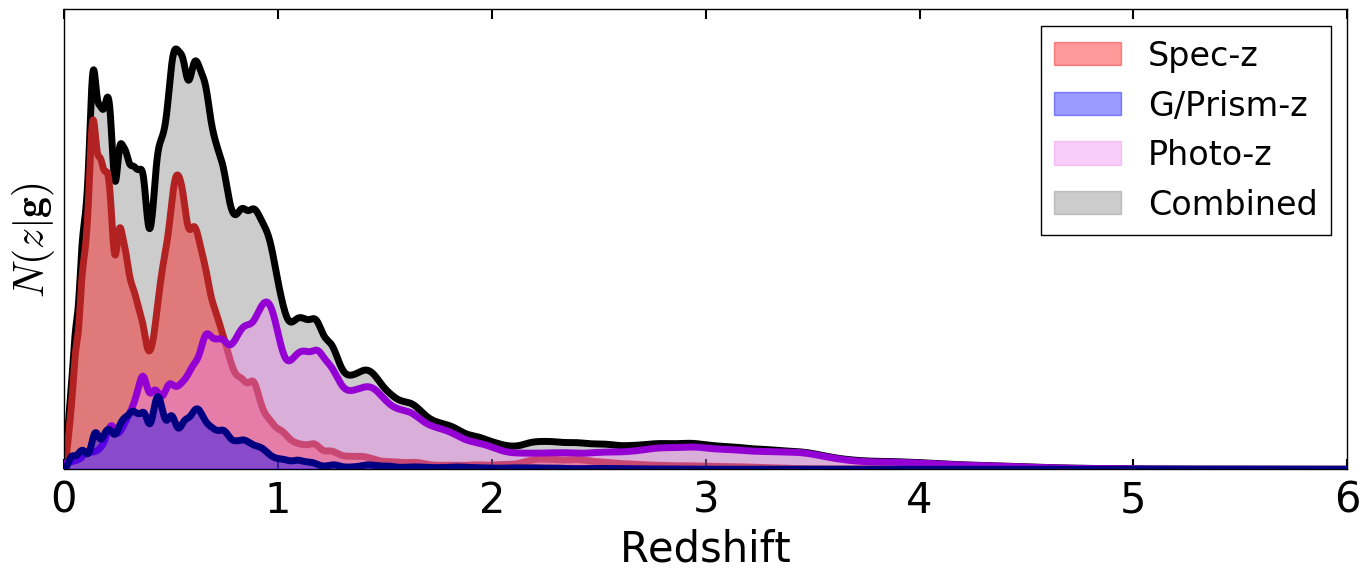

In [7]:
# plotting redshift distribution
figure(figsize=(14,6))

# spec-z
z_pdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx, lzeidx, data['redshift_type']==1,
                        rdict.grid, rdict.delta, Nobs, rdict.Ngrid) # smooth PDF generated using input dictionaries
z_pdf = z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # ln(1+z)->z density
plot(rdict.zgrid_highres, z_pdf, lw=5, color='firebrick', zorder=2)
fill_between(rdict.zgrid_highres, z_pdf, color='red', alpha=0.4, zorder=2, label='Spec-z')

# g/prism-z
z_pdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx, lzeidx, data['redshift_type']==2,
                        rdict.grid, rdict.delta, Nobs, rdict.Ngrid) # smooth PDF generated using input dictionaries
z_pdf = z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # ln(1+z)->z density
plot(rdict.zgrid_highres, z_pdf, lw=5, color='navy', zorder=4)
fill_between(rdict.zgrid_highres, z_pdf, color='blue', alpha=0.4, zorder=4, label='G/Prism-z')

# multiband photo-z
z_pdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx, lzeidx, data['redshift_type']==3,
                        rdict.grid, rdict.delta, Nobs, rdict.Ngrid) # smooth PDF generated using input dictionaries
z_pdf = z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # ln(1+z)->z density
plot(rdict.zgrid_highres, z_pdf, lw=5, color='darkviolet', zorder=3)
fill_between(rdict.zgrid_highres, z_pdf, color='violet', alpha=0.4, zorder=3, label='Photo-z')

# total
z_pdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx, lzeidx, ones(Nobs),
                        rdict.grid, rdict.delta, Nobs, rdict.Ngrid) # smooth PDF generated using input dictionaries
z_pdf = z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # ln(1+z)->z density
plot(rdict.zgrid_highres, z_pdf, lw=5, color='black', zorder=1)
fill_between(rdict.zgrid_highres, z_pdf, color='gray', alpha=0.4, zorder=1, label='Combined')

xlim([0, 6])
yticks([])
legend(loc='best', fontsize=24)
tight_layout()
xlabel('Redshift')
ylabel('$N(z|\mathbf{g})$')

## Posteriors

In [8]:
# initialize FRANKEN-Z instance
frankenz = fz.FRANKENZ(N_members=25, n_neighbors=10)

In [9]:
# compute log-likelihoods
model_obj, model_Nobj, model_ll, model_Nbands = frankenz.predict(phot, err, mask, phot, err, mask)

(0) (1) (2) (3) (4) (5) (6) (7) (8) (9) (10) (11) (12) (13) (14) (15) (16) (17) (18) (19) (20) (21) (22) (23) (24) 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 110000 115000 120000 125000 130000 135000 140000 145000 150000 155000 160000 165000 170000 175000 180000 185000 190000 195000 200000 205000 210000 215000 220000 225000 230000 235000 240000 245000 250000 255000 260000 265000 270000 275000 280000 285000 290000 295000 300000 305000 310000 315000 320000 325000 330000 335000 340000 345000 350000 355000 360000 365000 370000 done!


As with our SDSS run, the selection criteria for the spectroscopic sample are complicated/unknown, so we'll disregard that correction here. We also mask our original training object to properly do leave-one-out cross-validation.

In [10]:
# leave-one-out cross-validation
for i in xrange(Nobs):
    model_ll[i,model_obj[i]==i] = inf # -2lnP = +inf.

In [11]:
# compute posteriors
model_post = zeros(model_ll.shape)
model_evid = zeros(Nobs)
for i in arange(Nobs):
    Nm = model_Nobj[i] # number of models
    midx = model_obj[i,:Nm] # model indices
    ll = model_ll[i,:Nm] # log-likelihoods
    like = exp(-0.5*(ll-ll.min())) # scaled likelihoods
    model_evid[i] = like.sum() * exp(-0.5*ll.min())
    post = float64(like) # scaled posteriors
    post /= post.sum() # normalizing
    model_post[i,:Nm] = post

As before, let's see how our coverage looks.

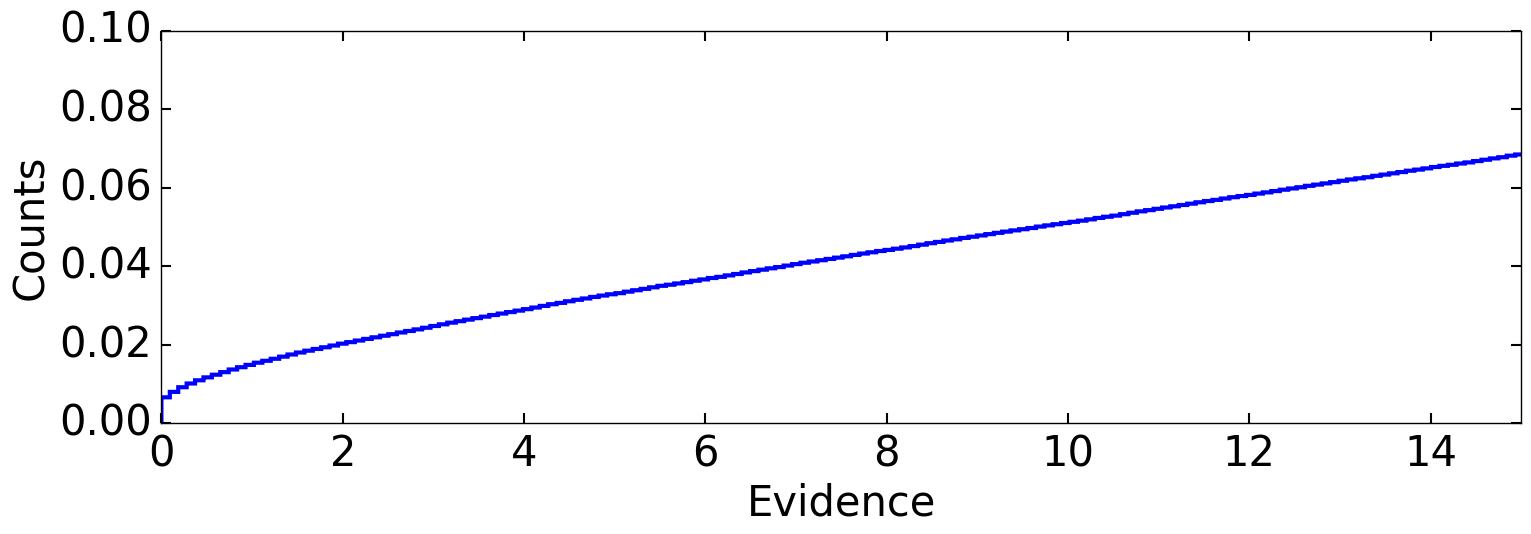

In [13]:
figure(figsize=(16,6))
h = hist(model_evid, 10000, histtype='step', lw=3, normed=True, cumulative=True)
xlabel('Evidence')
xlim([0,15])
ylabel('Counts')
ylim([0,0.1])
tight_layout()

In [14]:
pmask = arange(Nobs)[model_evid>10]
Ntrain = Nobs
Ntest = len(pmask)
print('Objects with reasonable coverage {:}/{:}'.format(Ntest, Ntrain))

Objects with reasonable coverage 354397/373429


In [15]:
# computing stacked posteriors
pstack = zeros(Ntrain)
for i in pmask:
    Nm = model_Nobj[i]
    midx = model_obj[i,:Nm]
    pstack[midx] += model_post[i,:Nm] # stacked posterior

In [16]:
# compute redshift PDF (truth)
z_pdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx[pmask], lzeidx[pmask], ones(Ntest),
                        rdict.grid, rdict.delta, Ntest, rdict.Ngrid) # smooth PDF generated using input dictionaries
z_pdf = z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # ln(1+z)->z density
z_pdf = interp(rdict.zgrid_out, rdict.zgrid_highres, z_pdf)
z_pdf /= z_pdf.sum() # normalizing

# compute redshift PDF (stacked)
z_trn = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx, lzeidx, pstack,
                        rdict.grid, rdict.delta, Ntrain, rdict.Ngrid) # smooth PDF generated using input dictionaries
z_trn = z_trn[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # ln(1+z)->z density
z_trn = interp(rdict.zgrid_out, rdict.zgrid_highres, z_trn)
z_trn /= z_trn.sum() # normalizing

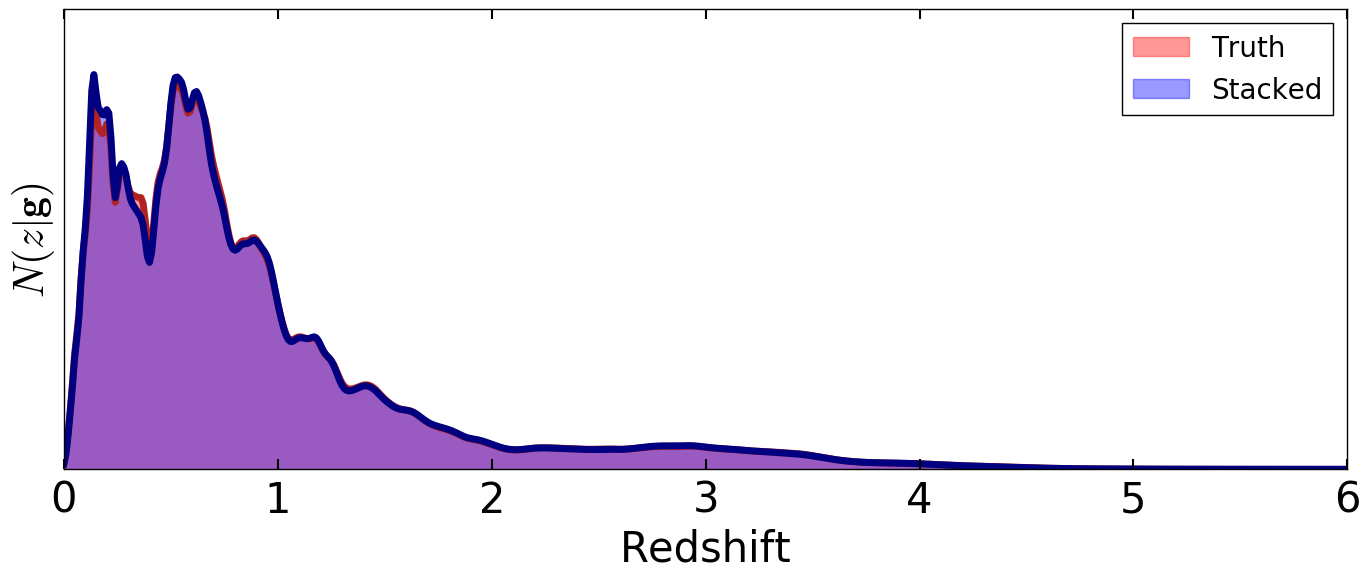

In [17]:
# plotting redshift distribution
figure(figsize=(14,6))

# testing
plot(rdict.zgrid_out, z_pdf, lw=5, color='firebrick')
fill_between(rdict.zgrid_out, z_pdf, color='red', alpha=0.4, label='Truth')

# training
plot(rdict.zgrid_out, z_trn, lw=5, color='navy')
fill_between(rdict.zgrid_out, z_trn, color='blue', alpha=0.4, label='Stacked')

xlim([0, 6])
yticks([])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
ylabel('$N(z|\mathbf{g})$')

## Population Inference: Posterior

In [18]:
Nsamples = 20 # number of samples

In [19]:
post_samples = zeros((Nsamples, Ntrain), dtype='int')
for i in xrange(Nsamples):
    sys.stdout.write(str(i)+' ')
    for j in pmask:
        Nm = model_Nobj[j]
        midx = model_obj[j,:Nm]
        post = model_post[j,:Nm]
        post_samples[i,midx] += multinomial(1, post) # sample object

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

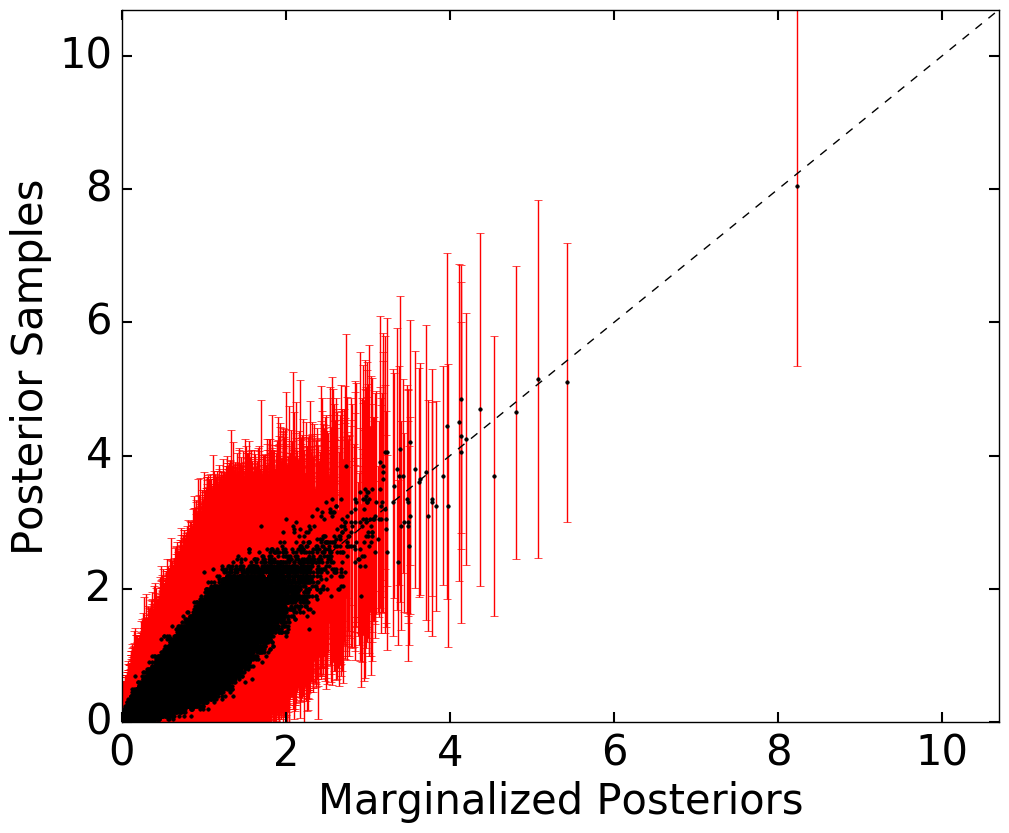

In [20]:
# plotting
figure(figsize=(20,9))
subplot(1,2,1)
plot([0,1e4], [0,1e4], 'k--', lw=1)
errorbar(pstack, post_samples.mean(axis=0), fmt='k.', yerr=post_samples.std(axis=0), ecolor='red', markersize=5, lw=1)
xlim([0, pstack.max()*1.3])
xlabel('Marginalized Posteriors')
ylim([0, pstack.max()*1.3])
ylabel('Posterior Samples')
tight_layout()

In [21]:
# draw redshift samples
post_samples_z = zeros((Nsamples, rdict.Nz_out))
for i in xrange(Nsamples):
    sys.stdout.write(str(i)+' ')
    lzsamps = []
    for j in xrange(Ntrain):
        for k in xrange(post_samples[i][j]):
            lzsamps.append( normal(lz[j], lze[j]+1e-10) ) # draw ln(1+z) samples
    lzidx_samp, lzeidx_samp = rdict.fit(lzsamps, ones(Ntest)*rdict.dlz)
    zpdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx_samp, lzeidx_samp, ones(Ntest), 
                           rdict.lzgrid_highres, rdict.dlz, Ntest, rdict.Nz_highres)
    zpdf = zpdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # downsample,convert ln(1+z)-->z
    post_samples_z[i] = interp(rdict.zgrid_out, rdict.zgrid_highres, zpdf) # resample
    post_samples_z[i] *= (Ntest / post_samples_z[i].sum()) # normalize

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

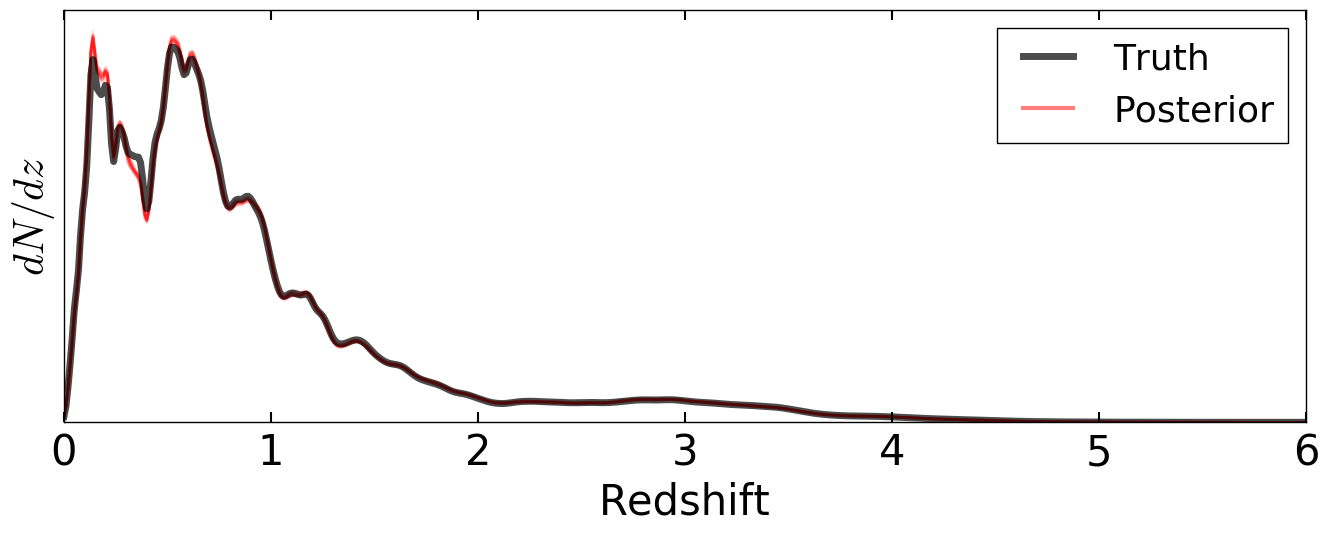

In [22]:
# plotting
zgrid = rdict.zgrid_out
figure(figsize=(14,6))
[plot(zgrid, post_samples_z[i], lw=2, color='red', alpha=0.1) for i in arange(Nsamples)]
plot(zgrid, z_pdf * Ntest, lw=5, color='black', alpha=0.7, label='Truth')
plot(zgrid, z_pdf*0.0-1e4, lw=3, color='red', alpha=0.5, label='Posterior')
xlabel('Redshift')
xlim([0, 6])
yticks([])
ylim([0, max(z_pdf * Ntest) * 1.1])
ylabel('$dN/dz$')
legend(fontsize=26, loc='best')
tight_layout()

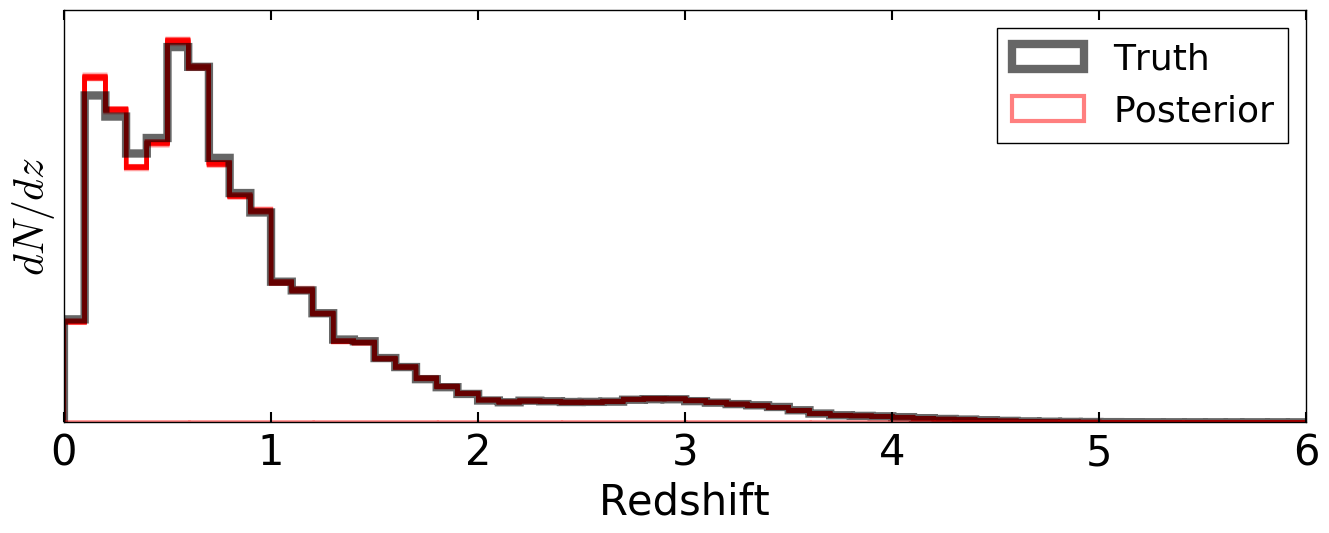

In [23]:
# plotting binned results
figure(figsize=(14,6))
[hist(zgrid, zgrid[::10], weights=post_samples_z[i], lw=3, histtype='step', color='red', alpha=0.3) 
 for i in arange(Nsamples)]
h = hist(zgrid, zgrid[::10], weights = z_pdf*Ntest, histtype='step', lw=6, color='black', alpha=0.6, label='Truth')
hist(zgrid, weights=z_pdf*1e-5, lw=3, histtype='step', color='red', alpha=0.5, label='Posterior')
xlabel('Redshift')
xlim([0, 6])
yticks([])
ylim([0, max(h[0]) * 1.1])
ylabel('$dN/dz$')
legend(fontsize=26, loc='best')
tight_layout()

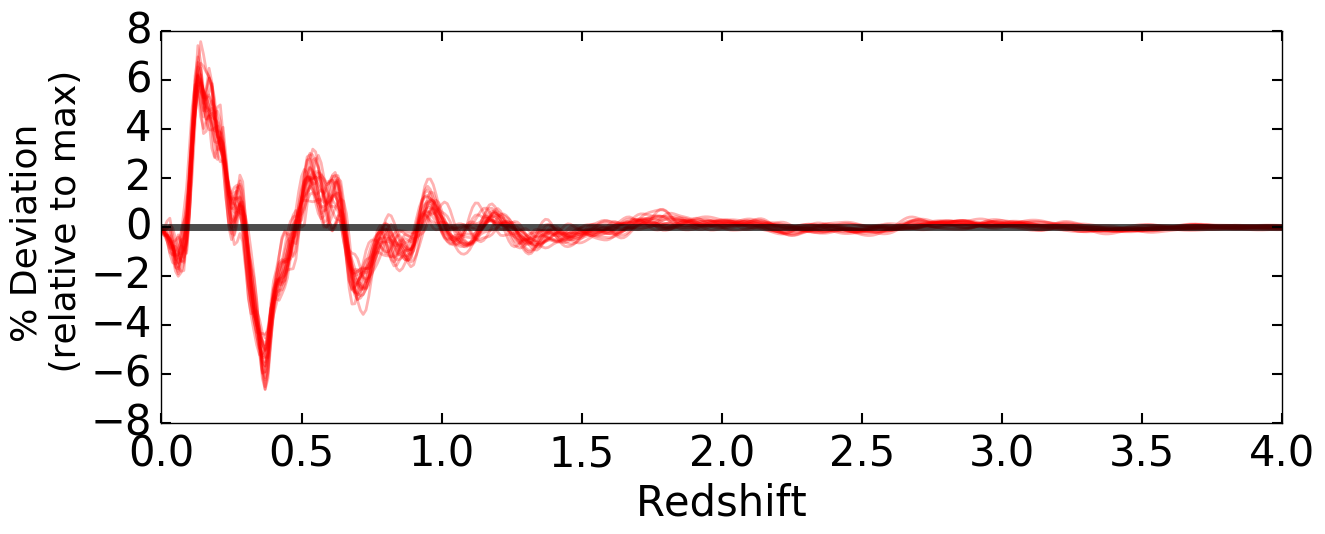

In [27]:
# plotting
figure(figsize=(14,6))
[plot(zgrid, 100* (post_samples_z[i] - z_pdf*Ntest) / (z_pdf.max()*Ntest), lw=2, color='red', alpha=0.3) 
 for i in arange(Nsamples)]
plot(zgrid, z_pdf * 0., lw=5, color='black', alpha=0.7)
xlabel('Redshift')
xlim([0, 4])
ylabel('% Deviation \n (relative to max)', fontsize=26)
tight_layout()

## Hierarchical Inference

In [28]:
# generate samples
Nmcmc = 200 # total number of MCMC draws
hier_samples_n = zeros((Nmcmc, Ntrain))
hier_samples_w = zeros((Nmcmc, Ntrain))

wt = ones(Ntrain) # initialize weights
for i in xrange(Nmcmc):
    sys.stdout.write(str(i)+' ')
    n = zeros(Ntrain) # number counts
    for j in pmask:
        Nm = model_Nobj[j]
        midx = model_obj[j,:Nm]
        post = model_post[j,:Nm] * wt[midx]
        post /= post.sum()
        n[midx] += multinomial(1, post) # stack multinomial draw
    wt = dirichlet(n + 1) * Ntest # sample population weight
    hier_samples_n[i], hier_samples_w[i] = n.copy(), wt.copy()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

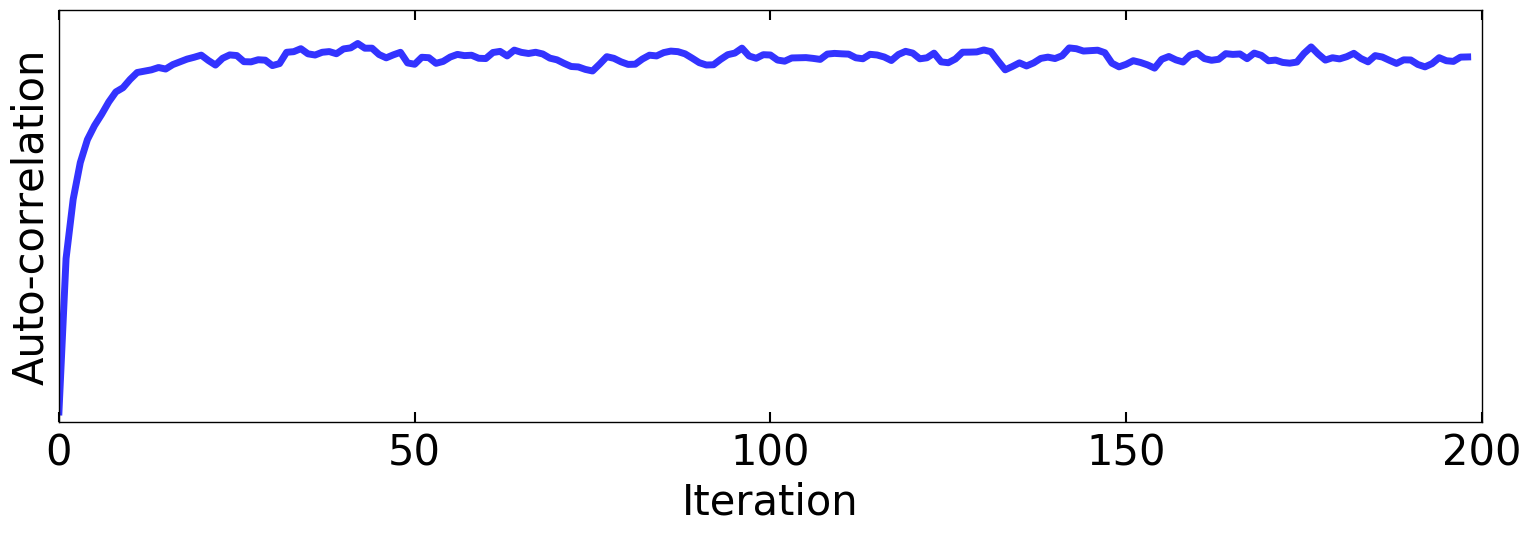

In [29]:
# plot lag=1 autocorrelation
figure(figsize=(16,6))
autocorr = array([correlate(hier_samples_n[i], hier_samples_n[i+1]) for i in arange(Nmcmc-1)]).flatten()
plot(arange(Nmcmc-1), autocorr, lw=5, color='blue', alpha=0.8, label='Original')
xlabel('Iteration')
ylabel('Auto-correlation')
yticks([])
xlim([0, Nmcmc])
tight_layout()

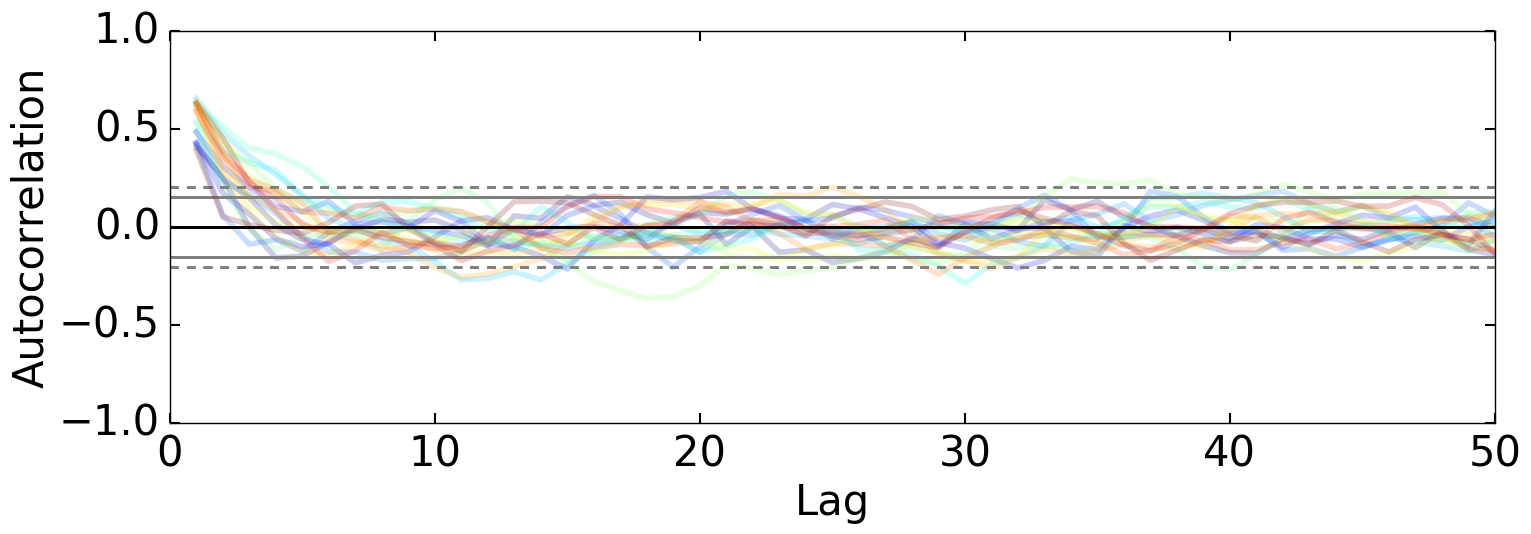

In [30]:
Nburnin = 40 # burn-in
indices = argsort(hier_samples_w[Nburnin:].mean(axis=0))[::-1] # sort from largest to smallest weights

# plot autocorrelation lag
figure(figsize=(16,6))
colors = get_cmap('jet')(linspace(0,1,20))
h = [autocorrelation_plot(hier_samples_w[Nburnin:,indices[i]], color=colors[i], lw=4, alpha=0.2) for i in xrange(20)]
xlim([0, 50])
tight_layout()

Let's look at the traces of a few samples.

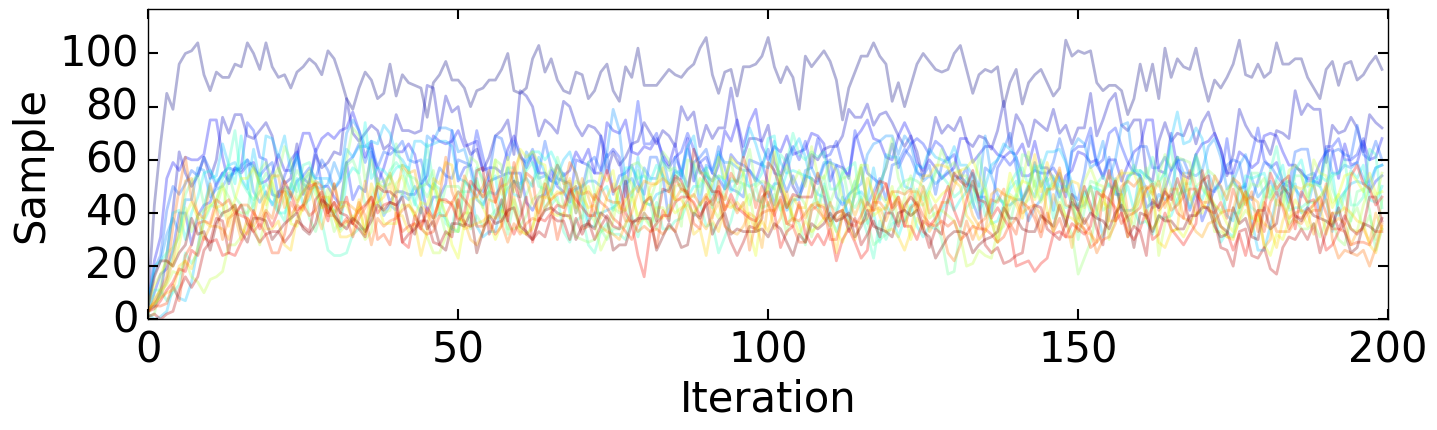

In [31]:
# plot samples
figure(figsize=(16,4))
for i in xrange(20):
    idx = indices[i]
    plot(arange(Nmcmc), hier_samples_n[:,idx], color=colors[i], lw=2, alpha=0.3)
ylim([max(0,hier_samples_n[Nburnin:,indices[:20]].min()-100), hier_samples_n[Nburnin:,indices[:20]].max()*1.1])
xlim([0, Nmcmc])
xlabel('Iteration')
ylabel('Sample')

In [32]:
# thinning
Nthin = 8
hier_samples_t = hier_samples_n[Nburnin::Nthin]

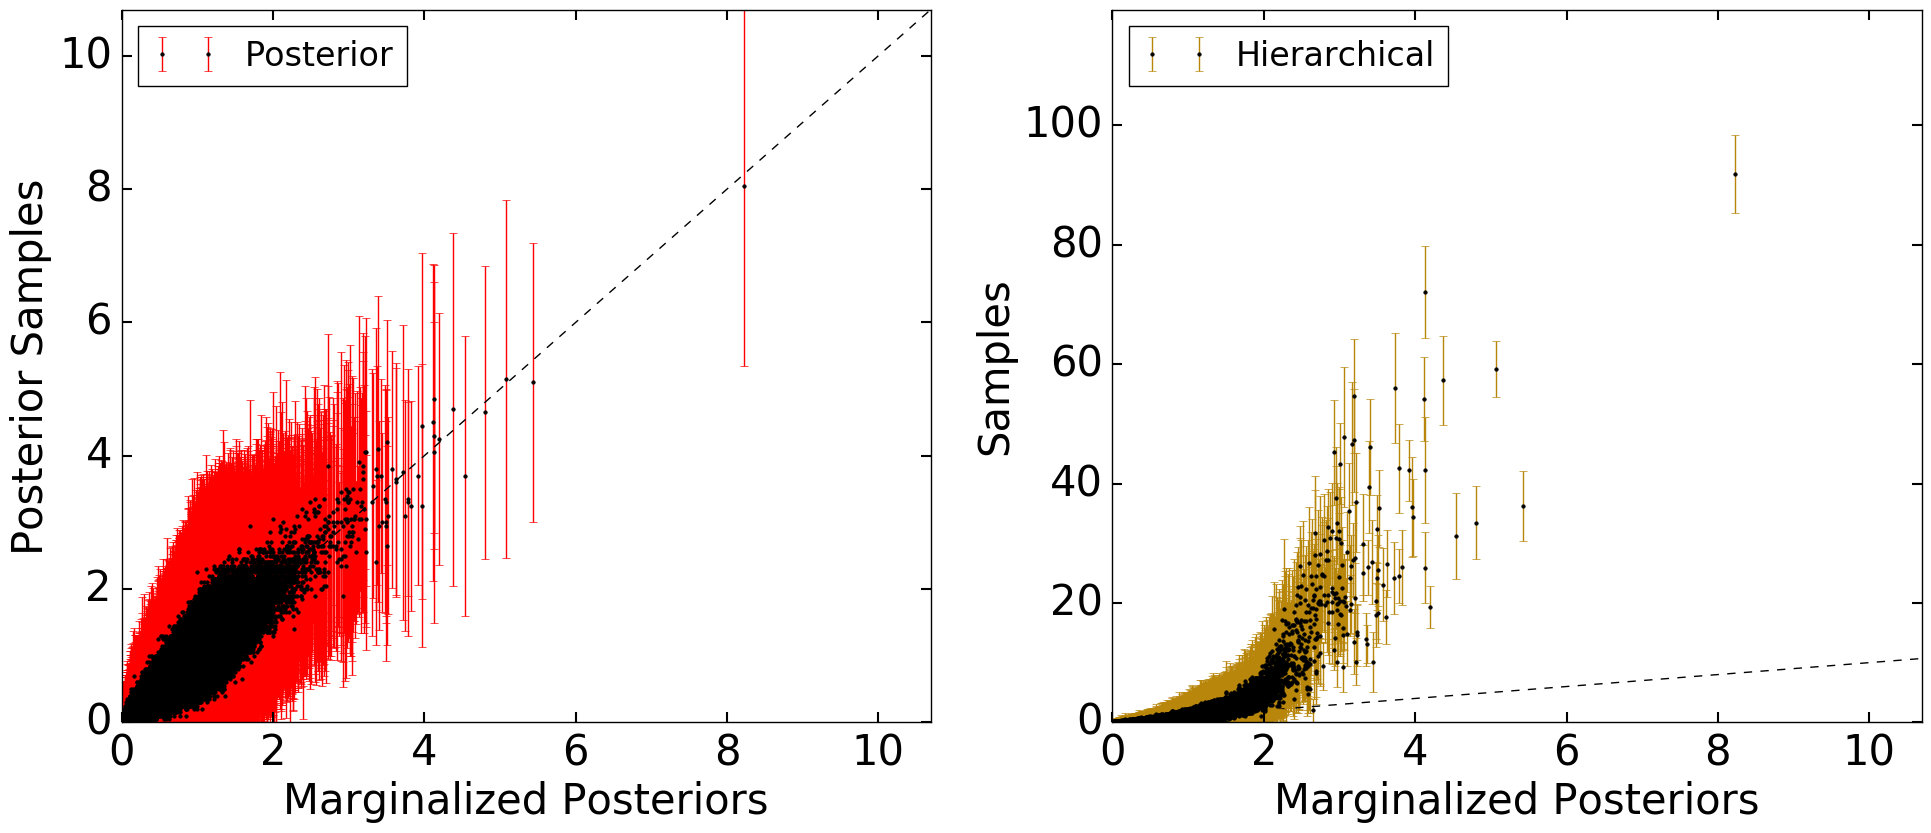

In [33]:
# plotting
figure(figsize=(20,9))
subplot(1,2,1)
plot([0,1e4], [0,1e4], 'k--', lw=1)
errorbar(pstack, post_samples.mean(axis=0), fmt='k.', yerr=post_samples.std(axis=0), 
         ecolor='red', markersize=5, lw=1, label='Posterior')
xlim([0, pstack.max()*1.3])
xlabel('Marginalized Posteriors')
ylim([0, pstack.max()*1.3])
ylabel('Posterior Samples')
legend(loc=2, fontsize=24)
tight_layout()
subplot(1,2,2)
plot([0,1e4], [0,1e4], 'k--', lw=1)
errorbar(pstack, hier_samples_t.mean(axis=0), fmt='k.', yerr=hier_samples_t.std(axis=0), 
         ecolor='darkgoldenrod', markersize=5, lw=1,
         label='Hierarchical')
xlim([0, pstack.max()*1.3])
xlabel('Marginalized Posteriors')
ylim([0, hier_samples_t.mean(axis=0).max()*1.3])
ylabel('Samples')
legend(loc=2, fontsize=24)
tight_layout()

In [34]:
# draw redshift samples
hier_samples_z = zeros((Nsamples, rdict.Nz_out))
for i in xrange(Nsamples):
    sys.stdout.write(str(i)+' ')
    lzsamps = []
    for j in xrange(Ntrain):
        for k in xrange(int(hier_samples_t[i][j])):
            lzsamps.append( normal(lz[j], lze[j]+1e-10) ) # draw ln(1+z) samples
    lzidx_samp, lzeidx_samp = rdict.fit(lzsamps, ones(Ntest)*rdict.dlz)
    zpdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx_samp, lzeidx_samp, ones(Ntest), 
                           rdict.lzgrid_highres, rdict.dlz, Ntest, rdict.Nz_highres)
    zpdf = zpdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # downsample,convert ln(1+z)-->z
    hier_samples_z[i] = interp(rdict.zgrid_out, rdict.zgrid_highres, zpdf) # resample
    hier_samples_z[i] *= (Ntest / hier_samples_z[i].sum()) # normalize

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

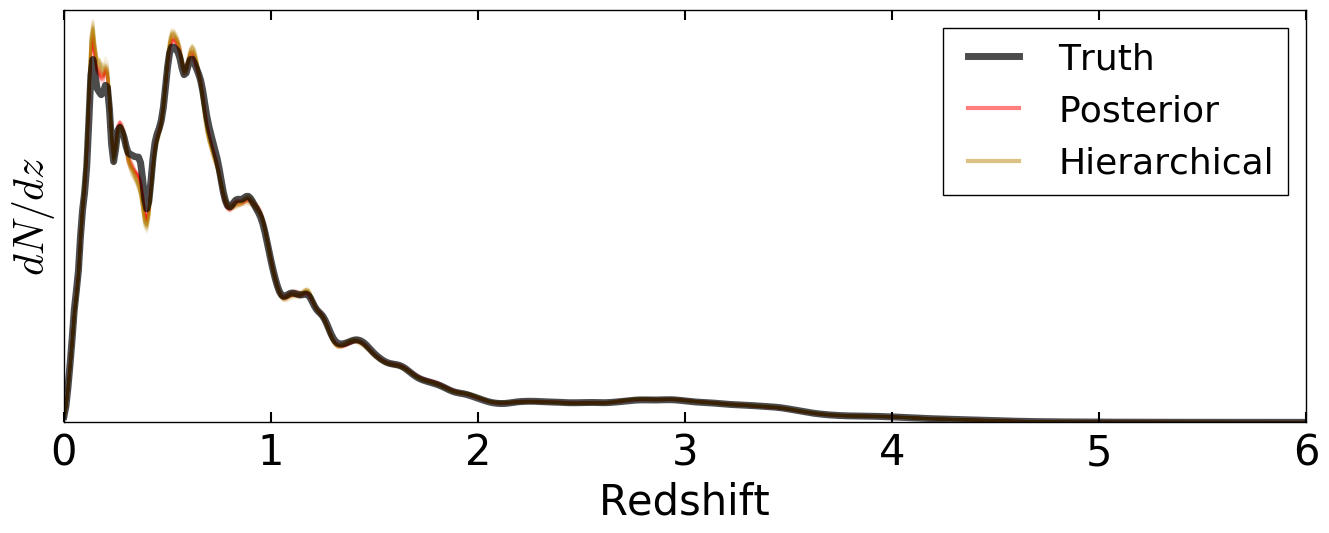

In [35]:
# plotting
zgrid = rdict.zgrid_out
figure(figsize=(14,6))
[plot(zgrid, post_samples_z[i], lw=2, color='red', alpha=0.1) for i in arange(Nsamples)]
[plot(zgrid, hier_samples_z[i], lw=2, color='darkgoldenrod', alpha=0.1) for i in arange(Nsamples)]
plot(zgrid, z_pdf * Ntest, lw=5, color='black', alpha=0.7, label='Truth')
plot(zgrid, z_pdf*0.0-1e4, lw=3, color='red', alpha=0.5, label='Posterior')
plot(zgrid, z_pdf*0.0-1e4, lw=3, color='darkgoldenrod', alpha=0.5, label='Hierarchical')
xlabel('Redshift')
xlim([0, 6])
yticks([])
ylim([0, max(z_pdf * Ntest) * 1.1])
ylabel('$dN/dz$')
legend(fontsize=26, loc='best')
tight_layout()

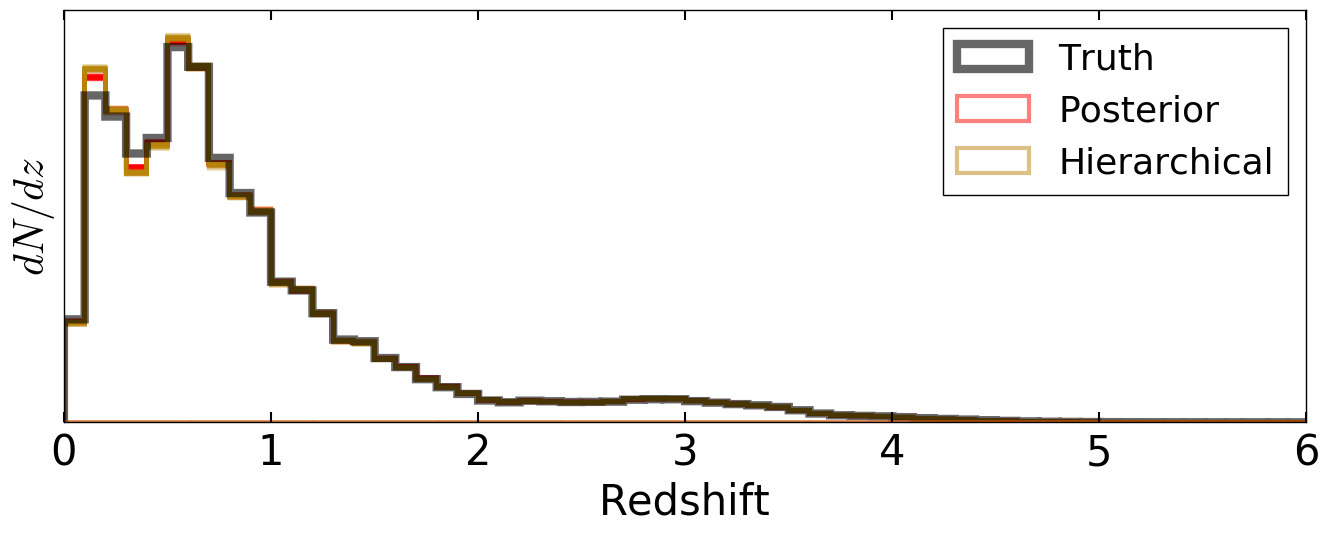

In [36]:
# plotting binned results
figure(figsize=(14,6))
[hist(zgrid, zgrid[::10], weights=post_samples_z[i], lw=3, histtype='step', color='red', alpha=0.3) 
 for i in arange(Nsamples)]
[hist(zgrid, zgrid[::10], weights=hier_samples_z[i], lw=3, histtype='step', color='darkgoldenrod', alpha=0.3) 
 for i in arange(Nsamples)]
h = hist(zgrid, zgrid[::10], weights = z_pdf*Ntest, histtype='step', lw=6, color='black', alpha=0.6, label='Truth')
hist(zgrid, weights=z_pdf*1e-5, lw=3, histtype='step', color='red', alpha=0.5, label='Posterior')
hist(zgrid, weights=z_pdf*1e-5, lw=3, histtype='step', color='darkgoldenrod', alpha=0.5, label='Hierarchical')
xlabel('Redshift')
xlim([0, 6])
yticks([])
ylim([0, max(h[0]) * 1.1])
ylabel('$dN/dz$')
legend(fontsize=26, loc='best')
tight_layout()

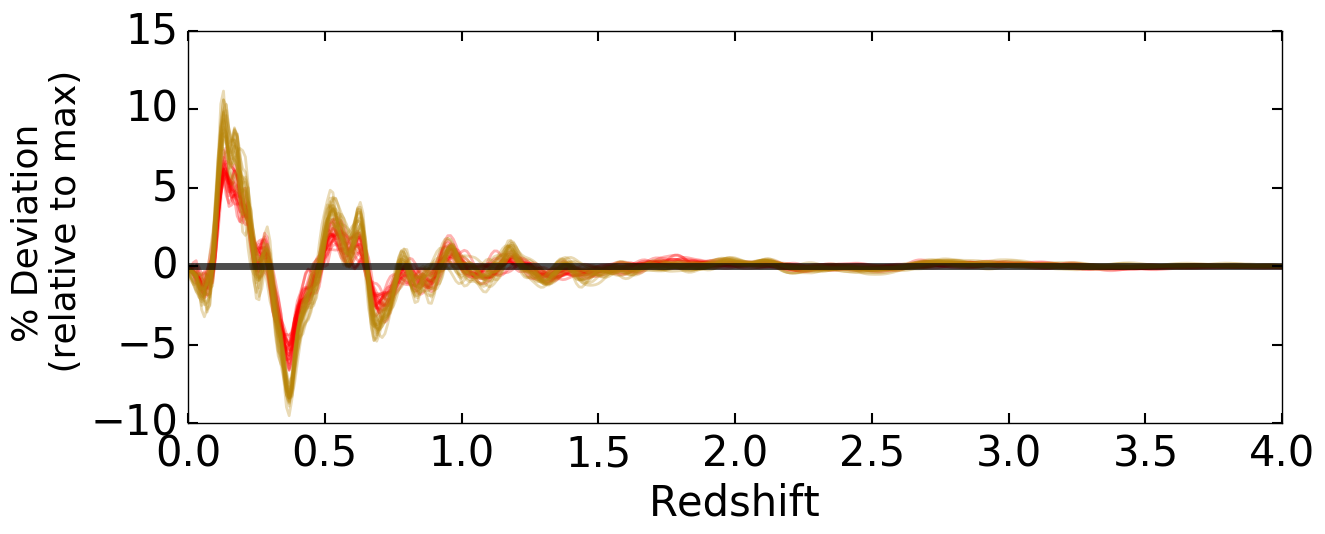

In [37]:
# plotting
figure(figsize=(14,6))
[plot(zgrid, 100* (post_samples_z[i] - z_pdf*Ntest) / (z_pdf.max()*Ntest), lw=2, color='red', alpha=0.3) 
 for i in arange(Nsamples)]
[plot(zgrid, 100* (hier_samples_z[i] - z_pdf*Ntest) / (z_pdf.max()*Ntest), lw=2, color='darkgoldenrod', alpha=0.3) 
 for i in arange(Nsamples)]
plot(zgrid, z_pdf * 0., lw=5, color='black', alpha=0.7)
xlabel('Redshift')
xlim([0, 4])
ylabel('% Deviation \n (relative to max)', fontsize=26)
tight_layout()

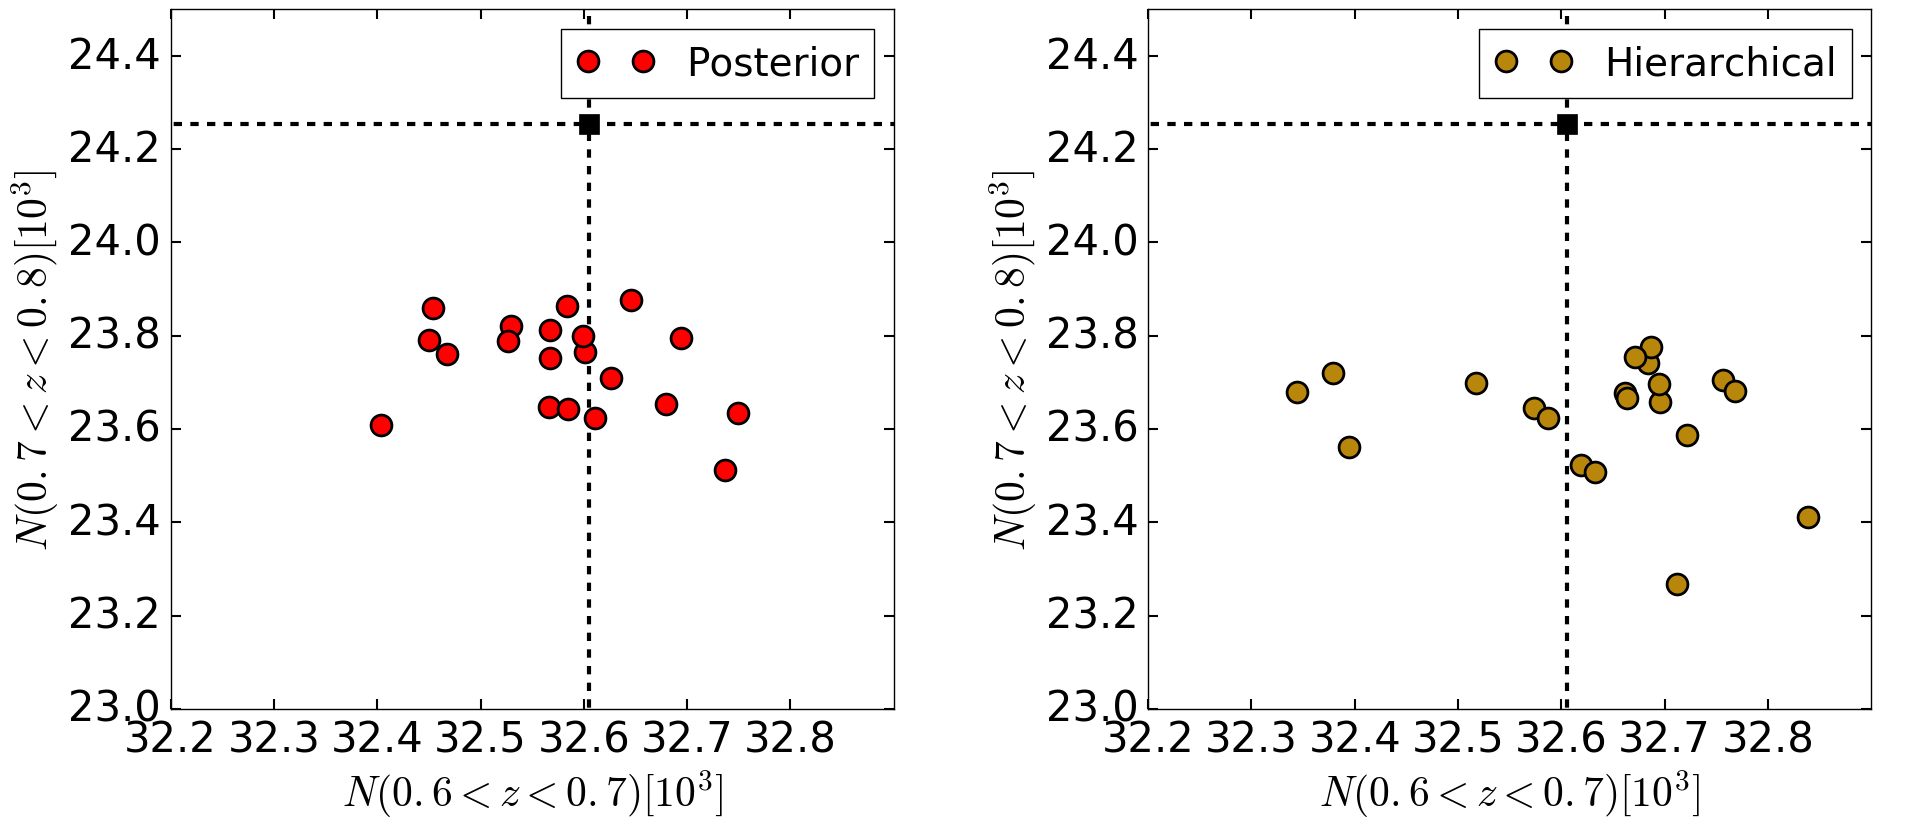

In [41]:
figure(figsize=(20,9))
subplot(1,2,1)
vlines(z_pdf[60:70].sum()*Ntest/1e3, 0, 100, colors='black', lw=3, linestyles='--')
hlines(z_pdf[70:80].sum()*Ntest/1e3, 0, 100, colors='black', lw=3, linestyles='--')
plot(z_pdf[60:70].sum()*Ntest/1e3, z_pdf[70:80].sum()*Ntest/1e3, 's', color='black', markersize=15)
plot(post_samples_z[:,60:70].sum(axis=1)/1e3, post_samples_z[:,70:80].sum(axis=1)/1e3, 'o', color='red', 
     label='Posterior', markersize=15, markeredgewidth=2)
ylim([23, 24.5])
xlim([32.2, 32.9])
xlabel('$N(0.6<z<0.7) [10^3]$')
ylabel('$N(0.7<z<0.8) [10^3]$')
legend(fontsize=28, loc=1)
tight_layout()
subplot(1,2,2)
vlines(z_pdf[60:70].sum()*Ntest/1e3, 0, 100, colors='black', lw=3, linestyles='--')
hlines(z_pdf[70:80].sum()*Ntest/1e3, 0, 100, colors='black', lw=3, linestyles='--')
plot(z_pdf[60:70].sum()*Ntest/1e3, z_pdf[70:80].sum()*Ntest/1e3, 's', color='black', markersize=15)
plot(hier_samples_z[:,60:70].sum(axis=1)/1e3, hier_samples_z[:,70:80].sum(axis=1)/1e3, 'o', 
     color='darkgoldenrod', label='Hierarchical', markersize=15, markeredgewidth=2)
ylim([23, 24.5])
xlim([32.2, 32.9])
xlabel('$N(0.6<z<0.7) [10^3]$')
ylabel('$N(0.7<z<0.8) [10^3]$')
legend(fontsize=28, loc=1)
tight_layout()

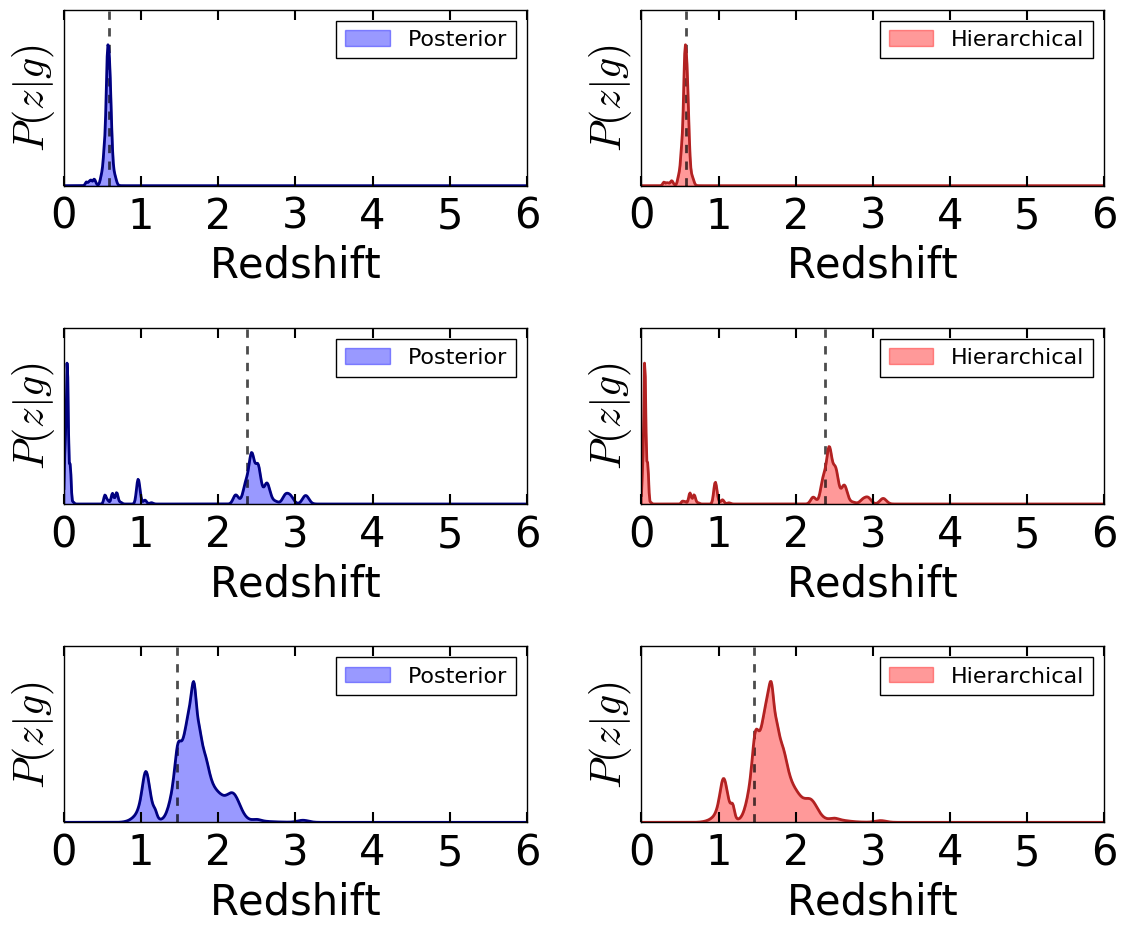

In [53]:
# plotting
indices = choice(pmask, size=3, replace=False)

# testing
figure(figsize=(12,10))
for i in xrange(3):
    idx = indices[i]
    Nm = model_Nobj[idx]
    midx, post = model_obj[idx,:Nm], model_post[idx,:Nm]
    hier_post = post * hier_samples_w[Nburnin::Nthin,midx]
    hier_post /= hier_post.sum(axis=1)[:,None]
    hier_post = hier_post.sum(axis=0)/Nsamples
    subplot(3,2,2*i+1)
    pdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx[midx], lzeidx[midx], post,
                          rdict.grid, rdict.delta, Nm, rdict.Ngrid) # smooth PDF generated using input dictionaries
    pdf = pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # ln(1+z)->z density
    pdf = interp(zgrid, rdict.zgrid_highres, pdf) # resampling
    pdf /= pdf.sum() # normalizing
    plot(zgrid, pdf, lw=2, color='navy')
    fill_between(zgrid, pdf, color='blue', alpha=0.4, label='Posterior')
    vlines(data['redshift'][idx], 0, 1e2, colors='black', linestyles='--', lw=2, alpha=0.7)
    xlabel('Redshift')
    xlim([0,6])
    xticks(arange(7))
    ylabel('$P(z|g)$')
    ylim([None, pdf.max()*1.25])
    yticks([])
    legend(fontsize=16)
    tight_layout()
    subplot(3,2,2*i+2)
    pdf = fz.pdf_kde_dict(rdict.sig_dict, rdict.sig_width, lzidx[midx], lzeidx[midx], hier_post,
                          rdict.grid, rdict.delta, Nm, rdict.Ngrid) # smooth PDF generated using input dictionaries
    pdf = pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres] / (1+rdict.zgrid_highres) # ln(1+z)->z density
    pdf = interp(zgrid, rdict.zgrid_highres, pdf) # resampling
    pdf /= pdf.sum() # normalizing
    plot(zgrid, pdf, lw=2, color='firebrick')
    fill_between(zgrid, pdf, color='red', alpha=0.4, label='Hierarchical')
    vlines(data['redshift'][idx], 0, 1e2, colors='black', linestyles='--', lw=2, alpha=0.7)
    xlabel('Redshift')
    xlim([0,6])
    xticks(arange(7))
    ylabel('$P(z|g)$')
    ylim([None, pdf.max()*1.25])
    yticks([])
    legend(fontsize=16)
    tight_layout()